# Using ConstControl to control other controllers


This tutorial shows how to use ConstControl to control other controllers in pandapower. In this example we set an attribute (a setpoint voltage) to the transformer tap changer controller.

First we need some imports. Specific for this example are:


* control -> Trafo Controller that uses local tap changer to control the voltage
* ConstControl -> "constant" controllers to update the voltage
* DFData -> The Dataframe Datasource. This Dataframe holds the time series to be calculated
* OutputWriter -> The output writer, which is required to write the outputs to the hard disk
* run_timeseries -> the "main" time series function, which basically calls the controller functions (to update the P, Q of the ConstControllers) and runpp.

In [1]:
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.control as control
import matplotlib.pyplot as plt
%matplotlib inline 

First we look at the time series example function. It follows these steps:

1. create the datasource (which contains the time series P values)
2. create the controllers to update the voltage
3. define the output writer and desired variables to be saved in the output object directory


In [2]:
def timeseries_example(net, output_dir):
    # 1. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # 2. create controllers 
    create_controllers(net, ds)
    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)
    # 3. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)
    return ow

We start by creating a simple example pandapower net consisting of five buses, a transformer, three lines, a load and a sgen. 

In [3]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net= pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

The data source is a simple pandas DataFrame. It contains random values for the load and the sgen P values ("profiles") and values within a range between 0.95 and 1.05 for the voltage setpoint.
Note that the profiles are identified by their column name ("load1_p", "sgen1_p" , "c"). 
The DFData(profiles) converts the DataFrame to the required format for the controllers.

In [4]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 20.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.
    profiles['c'] = 0.95 + np.random.random(n_timesteps) * (1.05-0.95)

    ds = DFData(profiles)
    
    # a + r*k
    # k = b-a
    # range between a and b within k

    return profiles, ds

First we created a transformer tap changer contoller c of class ContinuousTapControl and then use the ConstControl to set attribute (a voltage setpoint) of the tap changer controller. An attribute of an object can be set if it is specified as "object.attribute" (e.g. "object.vm_set_pu").

The parameters element_index and profile name should match. This way, it should be clear which profile belongs to which element. In this case we map:
* first controller in dataframe (element_index=[0]) to the profile_name "c"
* first sgen in dataframe (element_index=[0]) to the profile_name "sgen1_p"


In [5]:
def create_controllers(net, ds):
    c = control.ContinuousTapControl(net=net, tid=0, vm_set_pu=0.98, tol=1e-6)
    ConstControl(net, element='controller', variable='object.vm_set_pu', element_index=c.index, data_source=ds, profile_name='c')
    ConstControl(net, element='sgen', variable='res_load.0.98', element_index=0, data_source=ds, profile_name='sgen1_p')
   

create the output writer and desired variables to be saved in the attribute "output" of the output writer.
Instead of saving the whole net (which takes a lot of time), we extract only predefined outputs.
In this case we:
* save the results to "output" attribute of the output writer object
* log the variables "p_mw" from "res_load", "vm_pu" from "res_bus" and two res_line variables.

In [6]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

Here we call the main time series function to calculate the desired results

In [7]:
net = simple_test_net()

ow = timeseries_example(net, None)
pp.timeseries.run_time_series.run_timeseries(net, time_steps=range(24))

Progress: |██████████████████████████████████████████████████| 100.0% Complete



## Plot results
Now let us plot the results.

In [8]:
def plot_results(ow, variable, title):
    p= ow.output[variable]
    p.plot(label=variable)
    plt.xlabel("time step")
    plt.ylabel(variable)
    plt.title(title)
    plt.grid()
    plt.show()

Now let us compare the setpoint for voltage and the resulting voltage. To this end, we access the results of the time series simulation directly from the output writer object (attribute "output"):

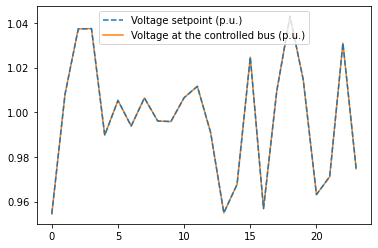

In [9]:
ax=net.controller.at[1,'object'].data_source.df['c'].plot(zorder=1, linestyle='--', label='Voltage setpoint (p.u.)')
ow.output['res_bus.vm_pu'][net.trafo.at[0, 'lv_bus']].plot(ax=ax, zorder=0, label='Voltage at the controlled bus (p.u.)')
ax.legend(loc='upper center')

As we can see, voltage setpoint of the transformer tap changer controller has been adjusted according to the values in the ConstControl.
Now, we can plot all the results of the time seriues simulation:

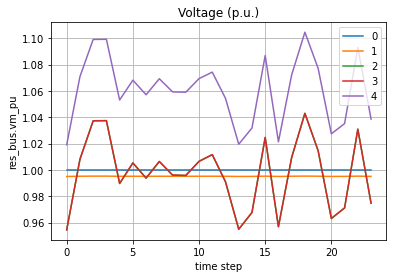

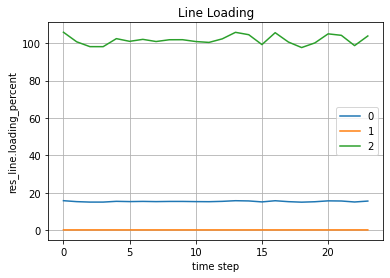

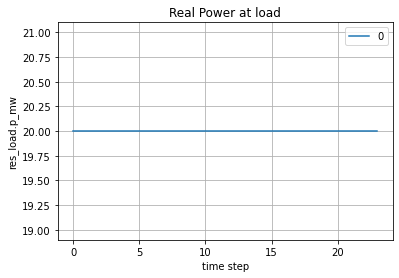

In [10]:
plot_results(ow, 'res_bus.vm_pu', 'Voltage (p.u.)')
plot_results(ow, 'res_line.loading_percent', 'Line Loading')
plot_results(ow, 'res_load.p_mw', 'Real Power at load')